<a href="https://colab.research.google.com/github/sheikabdul786/Document_Classification/blob/master/Multimodal_RAG_System_with_GPT_4o_and_Hugging_face_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-modal RAG System

Many documents contain a mixture of content types, including text, tables and images.

Yet, information captured in images is lost in most RAG applications.

With the emergence of multimodal LLMs, like [GPT-4o](https://openai.com/index/hello-gpt-4o/), it is worth considering how to utilize images in RAG Systems:

![](https://i.imgur.com/5BpuocV.png)


---

* Use a multimodal LLM (such as [GPT-4o](https://openai.com/index/hello-gpt-4o/), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images and tables
* Embed and retrieve image, table and text summaries with a reference to the raw images and tables
* Pass raw images, tables and text chunks to a multimodal LLM for answer synthesis   

---



* We will use [Unstructured](https://unstructured.io/) to parse images, text, and tables from documents (PDFs).
* We will use the [multi-vector retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) with [Chroma](https://www.trychroma.com/) and Redis to store raw text and images along with their summaries for retrieval.
* We will use GPT-4o for both image summarization (for retrieval) as well as final answer synthesis from join review of images and texts (or tables).





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Upgrade pip first
!pip install --upgrade pip
!pip install langchain
!pip install langchain-openai
!pip install langchain-chroma
!pip install langchain-experimental
!pip install --upgrade nltk
!pip install --upgrade langchain-community


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 36.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 117.6 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=45e39e576d8931b22a7902ab3465499daf971e97a1bc6a6063a20f5fbf5e329b
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
  Using cached transformers-4.45.1-py3-none-any.whl.metadata (44 kB)
  Using cached huggingface_hub-0.25.1-py3-none-any.whl.metadata (13 kB)
  Using cached tokenizers-0.20.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached transformers-4.45.1-py3-none-any.whl (9.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install --upgrade unstructured
!pip install --upgrade transformers huggingface_hub  # Additional dependencies
!pip install "unstructured[all-docs]"

In [ ]:
# install OCR dependencies for unstructured
!sudo apt-get install tesseract-ocr
!sudo apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!pip install htmltabletomd

## Data Loading

### Partition PDF tables, text, and images
  

In [ ]:
!wget https://sgp.fas.org/crs/misc/IF10244.pdf

--2024-10-05 07:27:23--  https://sgp.fas.org/crs/misc/IF10244.pdf
Resolving sgp.fas.org (sgp.fas.org)... 18.65.3.3, 18.65.3.95, 18.65.3.31, ...
Connecting to sgp.fas.org (sgp.fas.org)|18.65.3.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 435826 (426K) [application/pdf]
Saving to: ‘IF10244.pdf.1’

IF10244.pdf.1       100%[===================>] 425.61K   581KB/s    in 0.7s    

2024-10-05 07:27:24 (581 KB/s) - ‘IF10244.pdf.1’ saved [435826/435826]



In [ ]:
!ls ./IF10244.pdf

./IF10244.pdf


In [ ]:
!rm -rf ./figures

In [ ]:
# Install necessary libraries
#!pip install nltk
#!pip install langchain-community  # Ensure you have the required langchain-community package

# Import nltk and download the correct resource
import nltk
nltk.download('punkt')  # Correct resource name

# If necessary, set the path where NLTK stores its data (optional, usually works by default)
# nltk.data.path.append('/root/nltk_data')


doc = './IF10244.pdf'

# Import UnstructuredPDFLoader from the langchain_community library
from langchain_community.document_loaders import UnstructuredPDFLoader

# Use UnstructuredPDFLoader to process the PDF
loader = UnstructuredPDFLoader(
    file_path=doc,
    strategy='hi_res',
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",  # section-based chunking
    max_characters=4000,  # max size of chunks
    new_after_n_chars=4000,  # preferred size of chunks
    combine_text_under_n_chars=2000,  # smaller chunks < 2000 chars will be combined into a larger chunk
    mode='elements',
    image_output_dir_path='./figures'  # Optional: path where extracted images will be stored
)

# Load the document
data = loader.load()

# Check the loaded data
print(data)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[Document(metadata={'source': './IF10244.pdf', 'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2024-04-10T01:27:48', 'page_number': 1, 'orig_elements': 'eJzFWG1v2zYQ/iuEgQEJYGqkRElkgH3IUgTIgLXF0mIf2iKgJMrmKkuCXtJ6xf777kjZURxvWAM424fOPJHHu3uO99zlw7eFqczG1MOdLRYXZFGwhJVZqGme5BEVTGdU5tLQ1CSCCxWGSmSLJVlszKALPWg4822RN01X2FoPpnfrSm+bcbhbG7taDyAJQ8bgzCT+YothDVKeOmnb2HrAcx8+8IQFIOKB+rQku1UYp0Hi1nGkgvSIAPfDetFv+8Fs0Iu39qupbludm8Vf8KG0lRm2rXGf3v6K9tuNXpm7VjtLFj/mTT1AEH4s7WrsTD/9n3LKgz/a1cIZX69GOOMsXZh6tfjkpP1wt2kKW1rj4heyUFAmKGfvGL8I0wsh8XSLt9XjJjMdeo5GDeYrxmahA6I1+Ync1GXTbWy9IsPakMqsbF/pwd4bUpgMQkt6W+eGcMUFuWrqFZjZ26bWFfnN9EZ3+Zrcmu7egs+ofXL3Bv3EIBwCzVIjeZEV1GRpSYVJYqqyWNAkSTMhwiLj6oRAhyoNYoRSBcxBuRMotsNWhIE4JnBH/hXuwgwmHyA2dzng09+1XZPBNhZAvqjkeD6cDN73LUTPFOSXsQbwwH4WRnOAXuuuczC/wwNHgEri3PBIJTSVpaZCKkkl1yFNtGGFynSpeHrqFxmqKAhnbzIS0q9jEeMLPFz7/c8DScZhkr4wSL/bqihtZ8jtAFj0g837OUbv7FAdfURFHGlpZEJVmSsqkgR+xSanLIt1maQmlDw6NTaRZEE6w0ayOBC4lpEIoqdrv/952KgYys//hE1PNAA01i3cVMODcrIl

In [ ]:
len(data)

7

In [ ]:
[doc.metadata['category'] for doc in data]

['CompositeElement',
 'CompositeElement',
 'Table',
 'CompositeElement',
 'CompositeElement',
 'Table',
 'CompositeElement']

In [ ]:
data[0]

Document(metadata={'source': './IF10244.pdf', 'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2024-04-10T01:27:48', 'page_number': 1, 'orig_elements': 'eJzFWG1v2zYQ/iuEgQEJYGqkRElkgH3IUgTIgLXF0mIf2iKgJMrmKkuCXtJ6xf777kjZURxvWAM424fOPJHHu3uO99zlw7eFqczG1MOdLRYXZFGwhJVZqGme5BEVTGdU5tLQ1CSCCxWGSmSLJVlszKALPWg4822RN01X2FoPpnfrSm+bcbhbG7taDyAJQ8bgzCT+YothDVKeOmnb2HrAcx8+8IQFIOKB+rQku1UYp0Hi1nGkgvSIAPfDetFv+8Fs0Iu39qupbludm8Vf8KG0lRm2rXGf3v6K9tuNXpm7VjtLFj/mTT1AEH4s7WrsTD/9n3LKgz/a1cIZX69GOOMsXZh6tfjkpP1wt2kKW1rj4heyUFAmKGfvGL8I0wsh8XSLt9XjJjMdeo5GDeYrxmahA6I1+Ync1GXTbWy9IsPakMqsbF/pwd4bUpgMQkt6W+eGcMUFuWrqFZjZ26bWFfnN9EZ3+Zrcmu7egs+ofXL3Bv3EIBwCzVIjeZEV1GRpSYVJYqqyWNAkSTMhwiLj6oRAhyoNYoRSBcxBuRMotsNWhIE4JnBH/hXuwgwmHyA2dzng09+1XZPBNhZAvqjkeD6cDN73LUTPFOSXsQbwwH4WRnOAXuuuczC/wwNHgEri3PBIJTSVpaZCKkkl1yFNtGGFynSpeHrqFxmqKAhnbzIS0q9jEeMLPFz7/c8DScZhkr4wSL/bqihtZ8jtAFj0g837OUbv7FAdfURFHGlpZEJVmSsqkgR+xSanLIt1maQmlDw6NTaRZEE6w0ayOBC4lpEIoqdrv/952KgYys//hE1PNAA01i3cVMODcrIlg

In [ ]:
data[2]

Document(metadata={'source': './IF10244.pdf', 'last_modified': '2024-04-10T01:27:48', 'text_as_html': '<table><tr><td/><td>2018</td><td>2019</td><td>2020</td><td>2021</td><td>2022</td></tr><tr><td>Number of Fires (thousands)</td></tr><tr><td>Federal</td><td>12.5</td><td>10.9</td><td>14.4</td><td>14.0</td><td>11.7</td></tr><tr><td>FS</td><td>5.6</td><td>5.3</td><td>6.7</td><td>6.2</td><td>59</td></tr><tr><td>Dol</td><td>7.0</td><td>5.3</td><td>7.6</td><td>7.6</td><td>5.8</td></tr><tr><td>Other</td><td>0.1</td><td>0.2</td><td>&lt;0.1</td><td>0.2</td><td>0.1</td></tr><tr><td>Nonfederal</td><td>45.6</td><td>39.6</td><td>44.6</td><td>45.0</td><td>$7.2</td></tr><tr><td>Total</td><td>58.1</td><td>50.5</td><td>59.0</td><td>59.0</td><td>69.0</td></tr><tr><td>Acres Burned (millions)</td></tr><tr><td>Federal</td><td>4.6</td><td>3.1</td><td>7.1</td><td>5.2</td><td>40</td></tr><tr><td>FS</td><td>2.3</td><td>0.6</td><td>48</td><td>41</td><td>19</td></tr><tr><td>Dol</td><td>2.3</td><td>2.3</td><td>2.

In [ ]:
from IPython.display import HTML, display, Markdown


In [ ]:
print(data[2].page_content)

2018 2019 2020 Number of Fires (thousands) Federal 12.5 10.9 14.4 FS 5.6 5.3 6.7 DOI 7.0 5.3 7.6 2021 14.0 6.2 7.6 11.7 5.9 5.8 Other 0.1 0.2 <0.1 0.2 0.1 Nonfederal 45.6 39.6 44.6 45.0 57.2 Total 58.1 50.5 59.0 59.0 69.0 Acres Burned (millions) Federal 4.6 3.1 7.1 5.2 4.0 FS 2.3 0.6 4.8 4.1 1.9 DOI 2.3 2.3 2.3 1.0 2.1 Other <0.1 <0.1 <0.1 <0.1 <0.1 Nonfederal 4.1 1.6 3.1 1.9 3.6 Total 8.8 4.7 10.1 7.1 7.6


In [ ]:
data[2].metadata['text_as_html']

'<table><tr><td/><td>2018</td><td>2019</td><td>2020</td><td>2021</td><td>2022</td></tr><tr><td>Number of Fires (thousands)</td></tr><tr><td>Federal</td><td>12.5</td><td>10.9</td><td>14.4</td><td>14.0</td><td>11.7</td></tr><tr><td>FS</td><td>5.6</td><td>5.3</td><td>6.7</td><td>6.2</td><td>59</td></tr><tr><td>Dol</td><td>7.0</td><td>5.3</td><td>7.6</td><td>7.6</td><td>5.8</td></tr><tr><td>Other</td><td>0.1</td><td>0.2</td><td>&lt;0.1</td><td>0.2</td><td>0.1</td></tr><tr><td>Nonfederal</td><td>45.6</td><td>39.6</td><td>44.6</td><td>45.0</td><td>$7.2</td></tr><tr><td>Total</td><td>58.1</td><td>50.5</td><td>59.0</td><td>59.0</td><td>69.0</td></tr><tr><td>Acres Burned (millions)</td></tr><tr><td>Federal</td><td>4.6</td><td>3.1</td><td>7.1</td><td>5.2</td><td>40</td></tr><tr><td>FS</td><td>2.3</td><td>0.6</td><td>48</td><td>41</td><td>19</td></tr><tr><td>Dol</td><td>2.3</td><td>2.3</td><td>2.3</td><td>1.0</td><td>2.1</td></tr><tr><td>Other</td><td>&lt;0.1</td><td>&lt;0.1</td><td>&lt;0.1</td><

In [ ]:
display(Markdown(data[2].metadata['text_as_html']))

<table><tr><td/><td>2018</td><td>2019</td><td>2020</td><td>2021</td><td>2022</td></tr><tr><td>Number of Fires (thousands)</td></tr><tr><td>Federal</td><td>12.5</td><td>10.9</td><td>14.4</td><td>14.0</td><td>11.7</td></tr><tr><td>FS</td><td>5.6</td><td>5.3</td><td>6.7</td><td>6.2</td><td>59</td></tr><tr><td>Dol</td><td>7.0</td><td>5.3</td><td>7.6</td><td>7.6</td><td>5.8</td></tr><tr><td>Other</td><td>0.1</td><td>0.2</td><td>&lt;0.1</td><td>0.2</td><td>0.1</td></tr><tr><td>Nonfederal</td><td>45.6</td><td>39.6</td><td>44.6</td><td>45.0</td><td>$7.2</td></tr><tr><td>Total</td><td>58.1</td><td>50.5</td><td>59.0</td><td>59.0</td><td>69.0</td></tr><tr><td>Acres Burned (millions)</td></tr><tr><td>Federal</td><td>4.6</td><td>3.1</td><td>7.1</td><td>5.2</td><td>40</td></tr><tr><td>FS</td><td>2.3</td><td>0.6</td><td>48</td><td>41</td><td>19</td></tr><tr><td>Dol</td><td>2.3</td><td>2.3</td><td>2.3</td><td>1.0</td><td>2.1</td></tr><tr><td>Other</td><td>&lt;0.1</td><td>&lt;0.1</td><td>&lt;0.1</td><td>&lt;0.1</td><td>&lt;0.1</td></tr><tr><td>Nonfederal</td><td>4.1</td><td>1.6</td><td>3.1</td><td>Lg</td><td>3.6</td></tr><tr><td>Total</td><td>8.8</td><td>4.7</td><td>10.1</td><td>7.1</td><td>7.6</td></tr></table>

Since unstructured extracts the text from the table without any borders, we can use the HTML text and put it directly in prompts (LLMs understand HTML tables well) or even better convert HTML tables to Markdown tables as below

In [ ]:
import htmltabletomd

md_table = htmltabletomd.convert_table(data[2].metadata['text_as_html'])
print(md_table)

| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
|  | 2018 | 2019 | 2020 | 2021 | 2022 |
| Number of Fires (thousands) |
| Federal | 12.5 | 10.9 | 14.4 | 14.0 | 11.7 |
| FS | 5.6 | 5.3 | 6.7 | 6.2 | 59 |
| Dol | 7.0 | 5.3 | 7.6 | 7.6 | 5.8 |
| Other | 0.1 | 0.2 | &lt;0.1 | 0.2 | 0.1 |
| Nonfederal | 45.6 | 39.6 | 44.6 | 45.0 | $7.2 |
| Total | 58.1 | 50.5 | 59.0 | 59.0 | 69.0 |
| Acres Burned (millions) |
| Federal | 4.6 | 3.1 | 7.1 | 5.2 | 40 |
| FS | 2.3 | 0.6 | 48 | 41 | 19 |
| Dol | 2.3 | 2.3 | 2.3 | 1.0 | 2.1 |
| Other | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 |
| Nonfederal | 4.1 | 1.6 | 3.1 | Lg | 3.6 |
| Total | 8.8 | 4.7 | 10.1 | 7.1 | 7.6 |



In [ ]:
md_table

'| | | | | | |\n| :--- | :--- | :--- | :--- | :--- | :--- |\n|  | 2018 | 2019 | 2020 | 2021 | 2022 |\n| Number of Fires (thousands) |\n| Federal | 12.5 | 10.9 | 14.4 | 14.0 | 11.7 |\n| FS | 5.6 | 5.3 | 6.7 | 6.2 | 59 |\n| Dol | 7.0 | 5.3 | 7.6 | 7.6 | 5.8 |\n| Other | 0.1 | 0.2 | &lt;0.1 | 0.2 | 0.1 |\n| Nonfederal | 45.6 | 39.6 | 44.6 | 45.0 | $7.2 |\n| Total | 58.1 | 50.5 | 59.0 | 59.0 | 69.0 |\n| Acres Burned (millions) |\n| Federal | 4.6 | 3.1 | 7.1 | 5.2 | 40 |\n| FS | 2.3 | 0.6 | 48 | 41 | 19 |\n| Dol | 2.3 | 2.3 | 2.3 | 1.0 | 2.1 |\n| Other | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 |\n| Nonfederal | 4.1 | 1.6 | 3.1 | Lg | 3.6 |\n| Total | 8.8 | 4.7 | 10.1 | 7.1 | 7.6 |\n'

In [ ]:
docs = []
tables = []

for doc in data:
    if doc.metadata['category'] == 'Table':
        tables.append(doc)
    elif doc.metadata['category'] == 'CompositeElement':
        docs.append(doc)

len(docs), len(tables)

(5, 2)

In [ ]:
for table in tables:
    table.page_content = htmltabletomd.convert_table(table.metadata['text_as_html'])

In [ ]:
for table in tables:
    print(table.page_content)
    print()

| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
|  | 2018 | 2019 | 2020 | 2021 | 2022 |
| Number of Fires (thousands) |
| Federal | 12.5 | 10.9 | 14.4 | 14.0 | 11.7 |
| FS | 5.6 | 5.3 | 6.7 | 6.2 | 59 |
| Dol | 7.0 | 5.3 | 7.6 | 7.6 | 5.8 |
| Other | 0.1 | 0.2 | &lt;0.1 | 0.2 | 0.1 |
| Nonfederal | 45.6 | 39.6 | 44.6 | 45.0 | $7.2 |
| Total | 58.1 | 50.5 | 59.0 | 59.0 | 69.0 |
| Acres Burned (millions) |
| Federal | 4.6 | 3.1 | 7.1 | 5.2 | 40 |
| FS | 2.3 | 0.6 | 48 | 41 | 19 |
| Dol | 2.3 | 2.3 | 2.3 | 1.0 | 2.1 |
| Other | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 |
| Nonfederal | 4.1 | 1.6 | 3.1 | Lg | 3.6 |
| Total | 8.8 | 4.7 | 10.1 | 7.1 | 7.6 |


| | | | | |
| :--- | :--- | :--- | :--- | :--- |
|  | 2019 | 2020 | 2021 | 2022 |
| Structures Burned | 963 | 17,904 | 5,972 | 2,717 |
| % Residences | 46% | 54% | 60% | 46% |




In [ ]:
! ls -l ./figures

total 144
-rw-r--r-- 1 root root 27929 Oct  5 07:28 figure-1-1.jpg
-rw-r--r-- 1 root root 27182 Oct  5 07:28 figure-1-2.jpg
-rw-r--r-- 1 root root 26589 Oct  5 07:28 figure-1-3.jpg
-rw-r--r-- 1 root root 26448 Oct  5 07:28 figure-2-4.jpg
-rw-r--r-- 1 root root 29260 Oct  5 07:28 figure-2-5.jpg


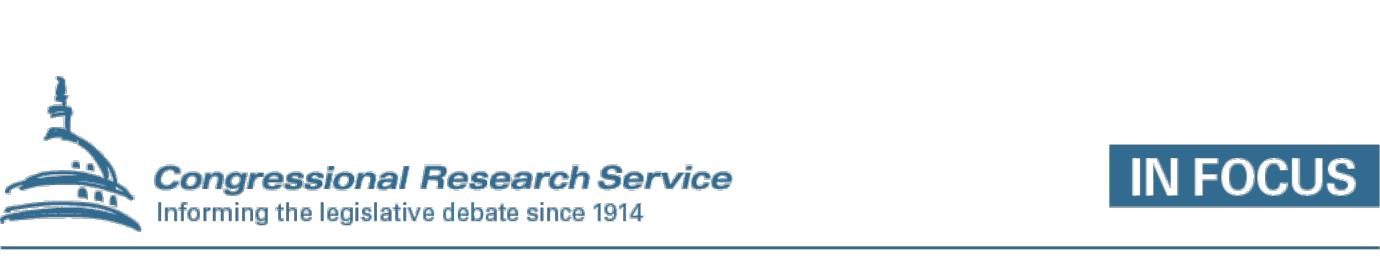

In [ ]:
from IPython.display import Image

Image('./figures/figure-1-1.jpg')

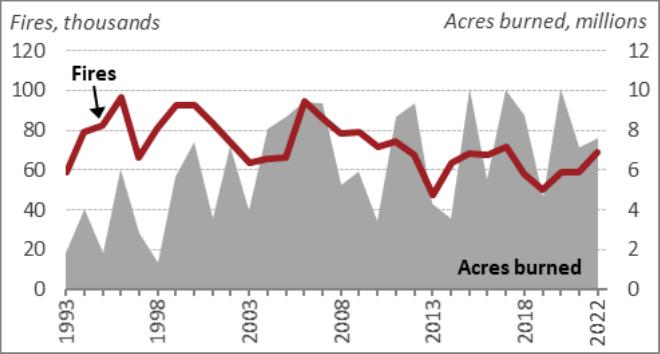

In [ ]:
Image('./figures/figure-1-2.jpg')

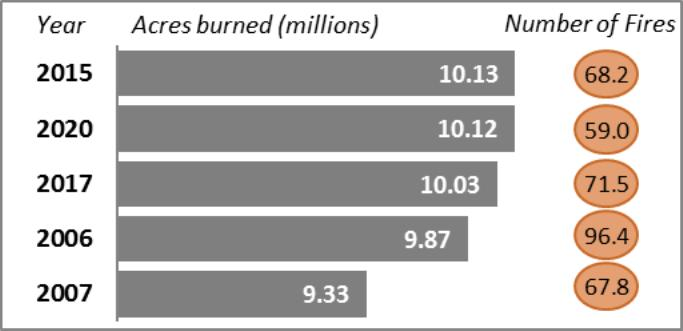

In [ ]:
Image('./figures/figure-1-3.jpg')

#### Enter Open AI API Key

In [ ]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


In [ ]:
import os

os.environ['OPENAI_API_KEY'] = "OPen AI key"

#### Load Connection to LLM

Here we create a connection to ChatGPT to use later in our chains

In [ ]:
from langchain_openai import ChatOpenAI

chatgpt = ChatOpenAI(model_name='gpt-3.5-turbo', temperature=0)

## Multi-vector retriever

Use [multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) to index image (and / or text, table) summaries, but retrieve raw images (along with raw texts or tables).

### Text and Table summaries

We will use GPT-4o to produce table and, text summaries.

Text summaries are advised if using large chunk sizes (e.g., as set above, we use 4k token chunks).

Summaries are used to retrieve raw tables and / or raw chunks of text.

In [ ]:
pip install --upgrade openai

In [ ]:
import time
from openai import OpenAIError
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text particularly for semantic retrieval.
These summaries will be embedded and used to retrieve the raw text or table elements.
Give a detailed summary of the table or text below that is well optimized for retrieval.
For any tables also add in a one-line description of what the table is about besides the summary.
Do not add additional words like Summary: etc.

Table or text chunk:
{element}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Use the correct model, such as `gpt-3.5-turbo` or `gpt-4`
chatgpt = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# Summary chain
summarize_chain = (
                    {"element": RunnablePassthrough()}
                      |
                    prompt
                      |
                    chatgpt
                      |
                    StrOutputParser()  # extracts the response as text and returns it as a string
)

# Initialize empty summaries
text_summaries = []
table_summaries = []

# Assuming `docs` and `tables` are lists of objects with `page_content` attributes
text_docs = [doc.page_content for doc in docs]
table_docs = [table.page_content for table in tables]

# Function to handle rate limits and insufficient quota errors
def run_with_retry(summarize_chain, docs, max_retries=3):
    retries = 0
    while retries < max_retries:
        try:
            # Lower concurrency to reduce load
            return summarize_chain.batch(docs, {"max_concurrency": 3})
        except OpenAIError as e:  # Catch the general OpenAIError
            if 'insufficient_quota' in str(e):
                print("Insufficient quota, skipping further execution.")
                return []  # Return empty list and stop execution if quota is exhausted
            print(f"OpenAI error: {e}")
            retries += 1
            print(f"Rate limit hit. Retrying {retries}/{max_retries} after delay...")
            # Exponential backoff: wait longer with each retry
            time.sleep(10 * retries)
    raise Exception("Exceeded maximum retries due to rate limiting or quota exhaustion.")

# Execute the chain with retry logic
text_summaries = run_with_retry(summarize_chain, text_docs)
table_summaries = run_with_retry(summarize_chain, table_docs)

len(text_summaries), len(table_summaries)


Insufficient quota, skipping further execution.
Insufficient quota, skipping further execution.


(0, 0)

In [ ]:
# from langchain_core.output_parsers import StrOutputParser
# from langchain_core.prompts import ChatPromptTemplate
# from langchain_openai import ChatOpenAI
# from langchain_core.runnables import RunnablePassthrough

# # Prompt
# prompt_text = """
# You are an assistant tasked with summarizing tables and text particularly for semantic retrieval.
# These summaries will be embedded and used to retrieve the raw text or table elements
# Give a detailed summary of the table or text below that is well optimized for retrieval.
# For any tables also add in a one line description of what the table is about besides the summary.
# Do not add additional words like Summary: etc.

# Table or text chunk:
# {element}
# """
# prompt = ChatPromptTemplate.from_template(prompt_text)

# # Summary chain
# summarize_chain = (
#                     {"element": RunnablePassthrough()}
#                       |
#                     prompt
#                       |
#                     chatgpt
#                       |
#                     StrOutputParser() # extracts the response as text and returns it as a string
# )

# # Initialize empty summaries
# text_summaries = []
# table_summaries = []

# text_docs = [doc.page_content for doc in docs]
# table_docs = [table.page_content for table in tables]

# text_summaries = summarize_chain.batch(text_docs, {"max_concurrency": 1})
# table_summaries = summarize_chain.batch(table_docs, {"max_concurrency": 1})

# len(text_summaries), len(table_summaries)

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
pip install transformers datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.




```
# Alter Model to Execute the prompting with Free Model using Hugging Face
```



In [ ]:
import time
from transformers import pipeline, AutoModelForSeq2SeqLM, AutoTokenizer

# Load Hugging Face summarization model and tokenizer
model_name = "facebook/bart-large-cnn"  # You can change this model to any Hugging Face-supported model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Hugging Face summarization pipeline
summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)

# Prompt for summarization
prompt_text = """
You are an assistant tasked with summarizing tables and text particularly for semantic retrieval.
These summaries will be embedded and used to retrieve the raw text or table elements.
Give a detailed summary of the table or text below that is well optimized for retrieval.
For any tables, also add in a one-line description of what the table is about besides the summary.
"""

# Function to summarize text using Hugging Face model
def summarize_text(texts, max_length=150, min_length=50):
    summaries = []
    for text in texts:
        try:
            summary = summarizer(text, max_length=max_length, min_length=min_length, do_sample=False)
            summaries.append(summary[0]['summary_text'])
        except Exception as e:
            print(f"Error summarizing: {e}")
            summaries.append("Error occurred during summarization.")
    return summaries

# Assuming `docs` and `tables` are lists of objects with `page_content` attributes
text_docs = [doc.page_content for doc in docs]
table_docs = [table.page_content for table in tables]

# Retry logic for handling errors (such as rate limits, but not needed for Hugging Face models)
def run_with_retry(summarizer_func, docs, max_retries=3):
    retries = 0
    while retries < max_retries:
        try:
            return summarizer_func(docs)  # Process summarization
        except Exception as e:  # Catch any general error
            print(f"Error: {e}")
            retries += 1
            print(f"Retrying {retries}/{max_retries} after delay...")
            time.sleep(10 * retries)  # Exponential backoff
    raise Exception("Exceeded maximum retries.")

# Execute the summarization with retry logic
text_summaries = run_with_retry(summarize_text, text_docs)
table_summaries = run_with_retry(summarize_text, table_docs)

# Output summary lengths
len(text_summaries), len(table_summaries)


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Your max_length is set to 150, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 150, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


(5, 2)

In [ ]:
text_summaries[0]

'Wildfires are unplanned fires, including lightning-caused fires, unauthorized human-causing fires, and escaped fires from prescribed burn projects. States are responsible for responding to wildfires that begin on nonfederal (state, local, and private) lands, except for lands protected by federal agencies under cooperative agreements. Nationwide data compiled by the National Interagency Coordination Center indicate that the number of annual wildfires is variable.'

In [ ]:
table_summaries[0]

'This table provides data on the number of fires and acres burned from 2018 to 2022, categorized by federal and nonfederal sources. \n\nNumber of Fires (thousands):\n- Federal: Ranges from 10.9K to 14.4K, peaking in 2020.\n- FS (Forest Service): Ranges from 5.3K to 6.7K, with an anomaly of 59K in 2022.\n- Dol (Department of the Interior): Ranges from 5.3K to 7.6K.\n- Other: Consistently low, mostly around 0.1K.\n- Nonfederal: Ranges from 39.6K to 45.6K, with an anomaly of $7.2K in 2022.\n- Total: Ranges from 50.5K to 69.0K.\n\nAcres Burned (millions):\n- Federal: Ranges from 3.1M to 7.1M, with an anomaly of 40M in 2022.\n- FS: Ranges from 0.6M to 48M, with an anomaly of 41M in 2021.\n- Dol: Consistently around 2.3M, with a dip to 1.0M in 2021.\n- Other: Consistently less than 0.1M.\n- Nonfederal: Ranges from 1.6M to 4.1M, with an anomaly of "Lg" in 2021.\n- Total: Ranges from 4.7M to 10.1M.'

### Image summaries

We will use [GPT-4o](https://openai.com/index/hello-gpt-4o/) to produce the image summaries.

* We pass base64 encoded images

In [ ]:
pip install transformers datasets torch Pillow

Below code is the replacement of Open AI model which will identify the pattern withng the image

using the Salesforce/blip-image-captioning-base model for image captioning, which generates descriptions for images.
You can replace this model with any other Hugging Face-supported image-to-text models if needed.

In [ ]:
import os
import base64
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

# Load the Hugging Face BLIP model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Function to encode image to base64
def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

# Function to generate a caption (summary) for an image using the Hugging Face model
def image_summarize(image_path, prompt=None):
    """Make image summary using Hugging Face BLIP model"""
    try:
        image = Image.open(image_path)
        inputs = processor(images=image, return_tensors="pt")
        output = model.generate(**inputs)
        caption = processor.decode(output[0], skip_special_tokens=True)
        return caption
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return "Error during image summarization"

# Function to generate image summaries and base64 encoded strings for images
def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Iterate over images in the specified directory
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)

            # Generate image caption (summary) using Hugging Face model
            summary = image_summarize(img_path)
            image_summaries.append(summary)

    return img_base64_list, image_summaries

# Example usage
IMG_PATH = './figures'
imgs_base64, image_summaries = generate_img_summaries(IMG_PATH)

# Output the results
for i, summary in enumerate(image_summaries):
    print(f"Image {i + 1} Summary: {summary}")


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Image 1 Summary: the logo for the international legislative committee
Image 2 Summary: a graph shows the number of fire in the area
Image 3 Summary: a table with the number of people who have been diagnosed
Image 4 Summary: a bar chart with the number of federal funds
Image 5 Summary: a graph shows the number of cases of the coronavirus in the us


Below code is working due to insuffcient quota that we need to upgrade place for use the OPen AI model

In [ ]:
# import base64
# import os

# from langchain_core.messages import HumanMessage


# def encode_image(image_path):
#     """Getting the base64 string"""
#     with open(image_path, "rb") as image_file:
#         return base64.b64encode(image_file.read()).decode("utf-8")


# def image_summarize(img_base64, prompt):
#     """Make image summary"""
#     chat = ChatOpenAI(model="gpt-4o", temperature=0)

#     msg = chat.invoke(
#         [
#             HumanMessage(
#                 content=[
#                     {"type": "text", "text": prompt},
#                     {
#                         "type": "image_url",
#                         "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
#                     },
#                 ]
#             )
#         ]
#     )
#     return msg.content


# def generate_img_summaries(path):
#     """
#     Generate summaries and base64 encoded strings for images
#     path: Path to list of .jpg files extracted by Unstructured
#     """

#     # Store base64 encoded images
#     img_base64_list = []

#     # Store image summaries
#     image_summaries = []

#     # Prompt
#     prompt = """You are an assistant tasked with summarizing images for retrieval.
#                 Remember these images could potentially contain graphs, charts or tables also.
#                 These summaries will be embedded and used to retrieve the raw image for question answering.
#                 Give a detailed summary of the image that is well optimized for retrieval.
#                 Do not add additional words like Summary: etc.
#              """

#     # Apply to images
#     for img_file in sorted(os.listdir(path)):
#         if img_file.endswith(".jpg"):
#             img_path = os.path.join(path, img_file)
#             base64_image = encode_image(img_path)
#             img_base64_list.append(base64_image)
#             image_summaries.append(image_summarize(base64_image, prompt))

#     return img_base64_list, image_summaries


# # Image summaries
# IMG_PATH = './figures'
# imgs_base64, image_summaries = generate_img_summaries(IMG_PATH)

In [ ]:
len(imgs_base64), len(image_summaries)

(5, 5)

In [ ]:
display(Image('./figures/figure-1-2.jpg'))

TypeError: 'module' object is not callable

In [ ]:
image_summaries[1]

'a graph shows the number of fire in the area'

### Add to vectorstore

Add raw docs and doc summaries to [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary):

* Store the raw texts, tables, and images in the `docstore` (here we are using Redis).
* Store the texts, table summaries, and image summaries in the `vectorstore` (here we are using Chroma) for efficient semantic retrieval.

In [ ]:
%%sh
curl -fsSL https://packages.redis.io/gpg | sudo gpg --dearmor -o /usr/share/keyrings/redis-archive-keyring.gpg
echo "deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/redis.list
sudo apt-get update  > /dev/null 2>&1
sudo apt-get install redis-stack-server  > /dev/null 2>&1
redis-stack-server --daemonize yes

deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb jammy main
Starting redis-stack-server, database path /var/lib/redis-stack


### Open AI Embedding Models

LangChain enables us to access Open AI embedding models which include the newest models: a smaller and highly efficient `text-embedding-3-small` model, and a larger and more powerful `text-embedding-3-large` model.

In [ ]:
from langchain_openai import OpenAIEmbeddings

# details here: https://openai.com/blog/new-embedding-models-and-api-updates
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

In [ ]:
docs[0]

Document(metadata={'source': './IF10244.pdf', 'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2024-04-10T01:27:48', 'page_number': 1, 'orig_elements': 'eJzFWG1v2zYQ/iuEgQEJYGqkRElkgH3IUgTIgLXF0mIf2iKgJMrmKkuCXtJ6xf777kjZURxvWAM424fOPJHHu3uO99zlw7eFqczG1MOdLRYXZFGwhJVZqGme5BEVTGdU5tLQ1CSCCxWGSmSLJVlszKALPWg4822RN01X2FoPpnfrSm+bcbhbG7taDyAJQ8bgzCT+YothDVKeOmnb2HrAcx8+8IQFIOKB+rQku1UYp0Hi1nGkgvSIAPfDetFv+8Fs0Iu39qupbludm8Vf8KG0lRm2rXGf3v6K9tuNXpm7VjtLFj/mTT1AEH4s7WrsTD/9n3LKgz/a1cIZX69GOOMsXZh6tfjkpP1wt2kKW1rj4heyUFAmKGfvGL8I0wsh8XSLt9XjJjMdeo5GDeYrxmahA6I1+Ync1GXTbWy9IsPakMqsbF/pwd4bUpgMQkt6W+eGcMUFuWrqFZjZ26bWFfnN9EZ3+Zrcmu7egs+ofXL3Bv3EIBwCzVIjeZEV1GRpSYVJYqqyWNAkSTMhwiLj6oRAhyoNYoRSBcxBuRMotsNWhIE4JnBH/hXuwgwmHyA2dzng09+1XZPBNhZAvqjkeD6cDN73LUTPFOSXsQbwwH4WRnOAXuuuczC/wwNHgEri3PBIJTSVpaZCKkkl1yFNtGGFynSpeHrqFxmqKAhnbzIS0q9jEeMLPFz7/c8DScZhkr4wSL/bqihtZ8jtAFj0g837OUbv7FAdfURFHGlpZEJVmSsqkgR+xSanLIt1maQmlDw6NTaRZEE6w0ayOBC4lpEIoqdrv/952KgYys//hE1PNAA01i3cVMODcrIlg

In [ ]:
pip install redis>=4.1.0

In [ ]:
pip install sentence-transformers chromadb redis langchain


In [ ]:
import uuid
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_community.storage import RedisStore
from langchain_community.utilities.redis import get_client
from langchain_chroma import Chroma
from langchain_core.documents import Document
from sentence_transformers import SentenceTransformer

# Wrapper class to integrate Hugging Face model into the format required by Chroma
class HuggingFaceEmbeddings:
    def __init__(self, model_name='sentence-transformers/all-MiniLM-L6-v2'):
        self.model = SentenceTransformer(model_name)

    def embed_documents(self, texts):
        """Generate embeddings for a list of texts."""
        return self.model.encode(texts, convert_to_tensor=False).tolist()

    def embed_query(self, query):
        """Generate embeddings for a single query (if needed by the retriever)."""
        return self.model.encode([query], convert_to_tensor=False).tolist()[0]

# Instantiate the Hugging Face embedding model
hf_embedding = HuggingFaceEmbeddings()

def create_multi_vector_retriever(
    docstore, vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=docstore,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever

# The vectorstore to use to index the summaries and their embeddings
chroma_db = Chroma(
    collection_name="mm_rag",
    embedding_function=hf_embedding,  # Use Hugging Face embedding function wrapped in a class
    collection_metadata={"hnsw:space": "cosine"},
)

# Initialize the storage layer - to store raw images, text, and tables
client = get_client('redis://localhost:6379')
redis_store = RedisStore(client=client)  # you can use filestore, memorystore, or any other DB store also

# Create the retriever
retriever_multi_vector = create_multi_vector_retriever(
    redis_store,
    chroma_db,
    text_summaries,
    text_docs,
    table_summaries,
    table_docs,
    image_summaries,
    imgs_base64,
)

In [ ]:
retriever_multi_vector

MultiVectorRetriever(vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x7c5e09520cd0>, docstore=<langchain_community.storage.redis.RedisStore object at 0x7c5e0a7635e0>, search_kwargs={})

## Multimodal RAG



In [ ]:
from IPython.display import HTML, display, Image
from PIL import Image
import base64
from io import BytesIO

def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Decode the base64 string
    img_data = base64.b64decode(img_base64)
    # Create a BytesIO object
    img_buffer = BytesIO(img_data)
    # Open the image using PIL
    img = Image.open(img_buffer)
    display(img)

### Check Retrieval

Examine retrieval; we get back images and tables also that are relevant to our question.

In [ ]:
# Check retrieval
query = "Tell me about the annual wildfires trend with acres burned"
docs = retriever_multi_vector.invoke(query, limit=5)

# We get 3 docs
len(docs)

4

In [ ]:
docs

[b'Source: NICC Wildland Fire Summary and Statistics annual reports.\n\nConflagrations\n\nOf the 1.6 million wildfires that have occurred since 2000, 254 exceeded 100,000 acres burned and 16 exceeded 500,000 acres burned. A small fraction of wildfires become catastrophic, and a small percentage of fires accounts for the vast majority of acres burned. For example, about 1% of wildfires become conflagrations\xe2\x80\x94raging, destructive fires\xe2\x80\x94but predicting which fires will \xe2\x80\x9cblow up\xe2\x80\x9d into conflagrations is challenging and depends on a multitude of factors, such as weather and geography. There have been 1,041 large or significant fires annually on average from 2018 through 2022. In 2022, 2% of wildfires were classified as large or significant (1,289); 45 exceeded 40,000 acres in size, and 17 exceeded 100,000 acres. For context, there were fewer large or significant wildfires in 2021 (943) but more in 2017 (1,409).\n\nIssues for Congress\n\nIssues Congres

In [ ]:
plt_img_base64(docs[2])

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7c5e0910f2e0>

In [ ]:
# Check retrieval
query = "Tell me about the percentage of residences burned by wildfires in 2022"
docs = retriever_multi_vector.invoke(query, limit=5)

# We get 4 docs
len(docs)

4

In [ ]:
docs

[b'| | | | | | |\n| :--- | :--- | :--- | :--- | :--- | :--- |\n|  | 2018 | 2019 | 2020 | 2021 | 2022 |\n| Number of Fires (thousands) |\n| Federal | 12.5 | 10.9 | 14.4 | 14.0 | 11.7 |\n| FS | 5.6 | 5.3 | 6.7 | 6.2 | 59 |\n| Dol | 7.0 | 5.3 | 7.6 | 7.6 | 5.8 |\n| Other | 0.1 | 0.2 | &lt;0.1 | 0.2 | 0.1 |\n| Nonfederal | 45.6 | 39.6 | 44.6 | 45.0 | $7.2 |\n| Total | 58.1 | 50.5 | 59.0 | 59.0 | 69.0 |\n| Acres Burned (millions) |\n| Federal | 4.6 | 3.1 | 7.1 | 5.2 | 40 |\n| FS | 2.3 | 0.6 | 48 | 41 | 19 |\n| Dol | 2.3 | 2.3 | 2.3 | 1.0 | 2.1 |\n| Other | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 |\n| Nonfederal | 4.1 | 1.6 | 3.1 | Lg | 3.6 |\n| Total | 8.8 | 4.7 | 10.1 | 7.1 | 7.6 |\n',
 b'| | | | | | |\n| :--- | :--- | :--- | :--- | :--- | :--- |\n|  | 2018 | 2019 | 2020 | 2021 | 2022 |\n| Number of Fires (thousands) |\n| Federal | 12.5 | 10.9 | 14.4 | 14.0 | 11.7 |\n| FS | 5.6 | 5.3 | 6.7 | 6.2 | 59 |\n| Dol | 7.0 | 5.3 | 7.6 | 7.6 | 5.8 |\n| Other | 0.1 | 0.2 | &lt;0.1 | 0.2 | 0.

In [ ]:
# Check retrieval
query = "Tell me about the number of acres burned by wildfires for the forest service in 2021"
docs = retriever_multi_vector.invoke(query, limit=5)

# We get 4 docs
len(docs)

4

In [ ]:
docs

[b'Source: NICC Wildland Fire Summary and Statistics annual reports.\n\nConflagrations\n\nOf the 1.6 million wildfires that have occurred since 2000, 254 exceeded 100,000 acres burned and 16 exceeded 500,000 acres burned. A small fraction of wildfires become catastrophic, and a small percentage of fires accounts for the vast majority of acres burned. For example, about 1% of wildfires become conflagrations\xe2\x80\x94raging, destructive fires\xe2\x80\x94but predicting which fires will \xe2\x80\x9cblow up\xe2\x80\x9d into conflagrations is challenging and depends on a multitude of factors, such as weather and geography. There have been 1,041 large or significant fires annually on average from 2018 through 2022. In 2022, 2% of wildfires were classified as large or significant (1,289); 45 exceeded 40,000 acres in size, and 17 exceeded 100,000 acres. For context, there were fewer large or significant wildfires in 2021 (943) but more in 2017 (1,409).\n\nIssues for Congress\n\nIssues Congres

### Utilities to separate retrieved elements

We need to bin the retrieved doc(s) into the correct parts of the GPT-4o prompt template.

Here we need to have text, table elements as one set of inputs and image elements as the other set of inputs as both require separate prompts in GPT-4o.

In [ ]:
import re
import base64

def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content.decode('utf-8')
        else:
            doc = doc.decode('utf-8')
        if looks_like_base64(doc) and is_image_data(doc):
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}

In [ ]:
# Check retrieval
query = "Tell me detailed statistics of the top 5 years with largest wildfire acres burned"
docs = retriever_multi_vector.invoke(query, limit=5)

# We get 3 docs
len(docs)

4

In [ ]:
docs

[b'Figure 2. Top Five Years with Largest Wildfire Acreage Burned Since 1960\n\nTable 1. Annual Wildfires and Acres Burned',
 b'Figure 2. Top Five Years with Largest Wildfire Acreage Burned Since 1960\n\nTable 1. Annual Wildfires and Acres Burned',
 b'| | | | | | |\n| :--- | :--- | :--- | :--- | :--- | :--- |\n|  | 2018 | 2019 | 2020 | 2021 | 2022 |\n| Number of Fires (thousands) |\n| Federal | 12.5 | 10.9 | 14.4 | 14.0 | 11.7 |\n| FS | 5.6 | 5.3 | 6.7 | 6.2 | 59 |\n| Dol | 7.0 | 5.3 | 7.6 | 7.6 | 5.8 |\n| Other | 0.1 | 0.2 | &lt;0.1 | 0.2 | 0.1 |\n| Nonfederal | 45.6 | 39.6 | 44.6 | 45.0 | $7.2 |\n| Total | 58.1 | 50.5 | 59.0 | 59.0 | 69.0 |\n| Acres Burned (millions) |\n| Federal | 4.6 | 3.1 | 7.1 | 5.2 | 40 |\n| FS | 2.3 | 0.6 | 48 | 41 | 19 |\n| Dol | 2.3 | 2.3 | 2.3 | 1.0 | 2.1 |\n| Other | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 |\n| Nonfederal | 4.1 | 1.6 | 3.1 | Lg | 3.6 |\n| Total | 8.8 | 4.7 | 10.1 | 7.1 | 7.6 |\n',
 b'| | | | | | |\n| :--- | :--- | :--- | :--- | :--- 

In [ ]:
is_image_data(docs[1].decode('utf-8'))

False

In [ ]:
r = split_image_text_types(docs)
r

{'images': [],
 'texts': ['Figure 2. Top Five Years with Largest Wildfire Acreage Burned Since 1960\n\nTable 1. Annual Wildfires and Acres Burned',
  'Figure 2. Top Five Years with Largest Wildfire Acreage Burned Since 1960\n\nTable 1. Annual Wildfires and Acres Burned',
  '| | | | | | |\n| :--- | :--- | :--- | :--- | :--- | :--- |\n|  | 2018 | 2019 | 2020 | 2021 | 2022 |\n| Number of Fires (thousands) |\n| Federal | 12.5 | 10.9 | 14.4 | 14.0 | 11.7 |\n| FS | 5.6 | 5.3 | 6.7 | 6.2 | 59 |\n| Dol | 7.0 | 5.3 | 7.6 | 7.6 | 5.8 |\n| Other | 0.1 | 0.2 | &lt;0.1 | 0.2 | 0.1 |\n| Nonfederal | 45.6 | 39.6 | 44.6 | 45.0 | $7.2 |\n| Total | 58.1 | 50.5 | 59.0 | 59.0 | 69.0 |\n| Acres Burned (millions) |\n| Federal | 4.6 | 3.1 | 7.1 | 5.2 | 40 |\n| FS | 2.3 | 0.6 | 48 | 41 | 19 |\n| Dol | 2.3 | 2.3 | 2.3 | 1.0 | 2.1 |\n| Other | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 |\n| Nonfederal | 4.1 | 1.6 | 3.1 | Lg | 3.6 |\n| Total | 8.8 | 4.7 | 10.1 | 7.1 | 7.6 |\n',
  '| | | | | | |\n| :--- | :-

## Multimodal RAG

### Build End-to-End Multimodal RAG Pipeline

Now let's connect our retriever, prompt instructions and build a multimodal RAG chain

In [ ]:
import uuid
from operator import itemgetter
from transformers import pipeline
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.messages import HumanMessage

# Initialize the text generation pipeline
text_generator = pipeline("text-generation", model="gpt2", truncation=True, pad_token_id=50256)

def multimodal_prompt_function(data_dict):
    """
    Create a multimodal prompt with both text and image context.
    """
    try:
        formatted_texts = "\n".join(data_dict["context"]["texts"])
        messages = []

        # Debug: Print the number of texts and images
        print(f"Number of texts: {len(data_dict['context']['texts'])}")
        print(f"Number of images: {len(data_dict['context']['images'])}")

        # Adding image(s) to the messages if present
        if data_dict["context"]["images"]:
            for idx, image in enumerate(data_dict["context"]["images"]):
                image_message = {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
                messages.append(image_message)
                print(f"Added image message {idx+1}: {image_message}")

        # Adding the text for analysis
        text_message = {
            "type": "text",
            "text": (
                f"""You are an analyst tasked with understanding detailed information and trends from text documents,
data tables, and charts and graphs in images.
You will be given context information below which will be a mix of text, tables, and images usually of charts or graphs.
Use this information to provide answers related to the user question.
Do not make up answers, use the provided context documents below and answer the question to the best of your ability.

User question:
{data_dict['question']}

Context documents:
{formatted_texts}

Answer:
"""
            ),
        }
        messages.append(text_message)
        print(f"Added text message: {text_message}")

        # Debugging: print the messages before returning
        print("Final Messages:", messages)

        # Return messages wrapped in a HumanMessage
        return [HumanMessage(content=messages)] if messages else [HumanMessage(content=["No valid context provided."])]
    except Exception as e:
        print(f"Error in multimodal_prompt_function: {e}")
        return [HumanMessage(content=["No valid context provided due to an error."])]

def generate_text_response(prompt):
    try:
        print("generate_text_response called with prompt:", prompt)
        if prompt and len(prompt) > 0 and len(prompt[0].content) > 0:
            # Ensure content is a list
            if not isinstance(prompt[0].content, list):
                print("Prompt content is not a list.")
                return "Invalid prompt structure."

            # Extract all text messages
            text_messages = [msg["text"] for msg in prompt[0].content if isinstance(msg, dict) and msg.get("type") == "text"]
            print(f"Extracted text messages: {text_messages}")
            if text_messages:
                combined_text = "\n".join(text_messages)
                print(f"Combined text for generation: {combined_text}")
                response = text_generator(combined_text, max_new_tokens=100, num_return_sequences=1)
                print(f"Text generator response: {response}")
                return response[0]["generated_text"]
        print("No valid prompt provided.")
        return "No valid prompt provided."
    except Exception as e:
        print(f"Error in generate_text_response: {e}")
        return "Error generating response."

# Ensure that retriever_multi_vector and split_image_text_types are defined
# For demonstration purposes, here's a simple mock implementation
def retriever_multi_vector(input_text):
    # Mock retrieval: return some dummy texts and images
    return {
        "texts": [
            "Wildfire statistics for 2018 show a significant increase in burned acres.",
            "In 2020, the trend continued with more acres burned compared to previous years."
        ],
        "images": [
            "base64_encoded_image_string_1",
            "base64_encoded_image_string_2"
        ]
    }

def split_image_text_types(retrieved_docs):
    # Mock splitting: assume retrieved_docs already have 'texts' and 'images'
    return retrieved_docs

# Create RAG chain
multimodal_rag = (
    {
        "context": itemgetter('context'),
        "question": itemgetter('input'),
    }
    | RunnableLambda(multimodal_prompt_function)
    | RunnableLambda(lambda prompt: generate_text_response(prompt) if prompt and len(prompt) > 0 else "No valid prompt provided.")
    | RunnablePassthrough()
)

# Pass input query to retriever and get context document elements
retrieve_docs = (
    itemgetter('input')
    | RunnableLambda(retriever_multi_vector)
    | RunnableLambda(split_image_text_types)
)

# Chain to get context and answer
multimodal_rag_w_sources = (
    RunnablePassthrough.assign(context=retrieve_docs)
    .assign(answer=multimodal_rag)
)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
# Run RAG chain
query = "Tell me detailed statistics of the top 5 years with largest wildfire acres burned"
try:
    print(f"Invoking RAG chain with query: {query}")
    response = multimodal_rag_w_sources.invoke({'input': query})
    print("RAG Chain Response:", response)
except Exception as e:
    import traceback
    print(f"Error during RAG chain invocation: {e}")
    traceback.print_exc()


Invoking RAG chain with query: Tell me detailed statistics of the top 5 years with largest wildfire acres burned
Number of texts: 2
Number of images: 2
Added image message 1: {'type': 'image_url', 'image_url': {'url': 'data:image/jpeg;base64,base64_encoded_image_string_1'}}
Added image message 2: {'type': 'image_url', 'image_url': {'url': 'data:image/jpeg;base64,base64_encoded_image_string_2'}}
Added text message: {'type': 'text', 'text': 'You are an analyst tasked with understanding detailed information and trends from text documents,\ndata tables, and charts and graphs in images.\nYou will be given context information below which will be a mix of text, tables, and images usually of charts or graphs.\nUse this information to provide answers related to the user question.\nDo not make up answers, use the provided context documents below and answer the question to the best of your ability.\n\nUser question:\nTell me detailed statistics of the top 5 years with largest wildfire acres burne

In [ ]:
# Run RAG chain
query = "Tell me detailed statistics of the top 5 years with largest wildfire acres burned"
response = multimodal_rag_w_sources.invoke({'input': query})
print(response)

Number of texts: 2
Number of images: 2
Added image message 1: {'type': 'image_url', 'image_url': {'url': 'data:image/jpeg;base64,base64_encoded_image_string_1'}}
Added image message 2: {'type': 'image_url', 'image_url': {'url': 'data:image/jpeg;base64,base64_encoded_image_string_2'}}
Added text message: {'type': 'text', 'text': 'You are an analyst tasked with understanding detailed information and trends from text documents,\ndata tables, and charts and graphs in images.\nYou will be given context information below which will be a mix of text, tables, and images usually of charts or graphs.\nUse this information to provide answers related to the user question.\nDo not make up answers, use the provided context documents below and answer the question to the best of your ability.\n\nUser question:\nTell me detailed statistics of the top 5 years with largest wildfire acres burned\n\nContext documents:\nWildfire statistics for 2018 show a significant increase in burned acres.\nIn 2020, the 

In [ ]:
def multimodal_rag_qa(query):
    response = multimodal_rag_w_sources.invoke({'input': query})
    print('=='*50)
    print('Answer:')
    display(Markdown(response['answer']))
    print('--'*50)
    print('Sources:')
    text_sources = response['context']['texts']
    img_sources = response['context']['images']
    for text in text_sources:
        display(Markdown(text))
        print()
    for img in img_sources:
        plt_img_base64(img)
        print()
    print('=='*50)

In [ ]:
query = "Tell me detailed statistics of the top 5 years with largest wildfire acres burned"
multimodal_rag_qa(query)

Number of texts: 2
Number of images: 2
Added image message 1: {'type': 'image_url', 'image_url': {'url': 'data:image/jpeg;base64,base64_encoded_image_string_1'}}
Added image message 2: {'type': 'image_url', 'image_url': {'url': 'data:image/jpeg;base64,base64_encoded_image_string_2'}}
Added text message: {'type': 'text', 'text': 'You are an analyst tasked with understanding detailed information and trends from text documents,\ndata tables, and charts and graphs in images.\nYou will be given context information below which will be a mix of text, tables, and images usually of charts or graphs.\nUse this information to provide answers related to the user question.\nDo not make up answers, use the provided context documents below and answer the question to the best of your ability.\n\nUser question:\nTell me detailed statistics of the top 5 years with largest wildfire acres burned\n\nContext documents:\nWildfire statistics for 2018 show a significant increase in burned acres.\nIn 2020, the 

You are an analyst tasked with understanding detailed information and trends from text documents,
data tables, and charts and graphs in images.
You will be given context information below which will be a mix of text, tables, and images usually of charts or graphs.
Use this information to provide answers related to the user question.
Do not make up answers, use the provided context documents below and answer the question to the best of your ability.

User question:
Tell me detailed statistics of the top 5 years with largest wildfire acres burned

Context documents:
Wildfire statistics for 2018 show a significant increase in burned acres.
In 2020, the trend continued with more acres burned compared to previous years.

Answer:

Please answer the question "How many wildfire acres do you experience every year and what year is the highest number of fire acres burned/wasteful?"

Wildfire is an extreme hot spot. Most people will not die due to burning or damages caused by a wildfire.

Climbing wildfires is common and it is extremely important to know where or how many persons are burning. This information is shared and will help you identify important places that are burning and areas that should be closed off

----------------------------------------------------------------------------------------------------
Sources:


Wildfire statistics for 2018 show a significant increase in burned acres.

In 2020, the trend continued with more acres burned compared to previous years.

Error: Invalid base64-encoded string: number of data characters (25) cannot be 1 more than a multiple of 4

In [ ]:
# Run RAG chain
query = "Tell me about the annual wildfires trend with acres burned"
multimodal_rag_qa(query)

Number of texts: 2
Number of images: 2
Added image message 1: {'type': 'image_url', 'image_url': {'url': 'data:image/jpeg;base64,base64_encoded_image_string_1'}}
Added image message 2: {'type': 'image_url', 'image_url': {'url': 'data:image/jpeg;base64,base64_encoded_image_string_2'}}
Added text message: {'type': 'text', 'text': 'You are an analyst tasked with understanding detailed information and trends from text documents,\ndata tables, and charts and graphs in images.\nYou will be given context information below which will be a mix of text, tables, and images usually of charts or graphs.\nUse this information to provide answers related to the user question.\nDo not make up answers, use the provided context documents below and answer the question to the best of your ability.\n\nUser question:\nTell me about the annual wildfires trend with acres burned\n\nContext documents:\nWildfire statistics for 2018 show a significant increase in burned acres.\nIn 2020, the trend continued with mo

You are an analyst tasked with understanding detailed information and trends from text documents,
data tables, and charts and graphs in images.
You will be given context information below which will be a mix of text, tables, and images usually of charts or graphs.
Use this information to provide answers related to the user question.
Do not make up answers, use the provided context documents below and answer the question to the best of your ability.

User question:
Tell me about the annual wildfires trend with acres burned

Context documents:
Wildfire statistics for 2018 show a significant increase in burned acres.
In 2020, the trend continued with more acres burned compared to previous years.

Answer:

This year, the average fire duration of wildfires reached 2:44:00

Where do your data come from, a recent fire or estimate

A previous fire or estimate can help you to understand the current forecast. Please check your existing web site to see if this is correct, for a better look, this data cannot be updated without the help of a Fire Engineer.

What is the forecast for 2017 and how often will it occur?

The number of fire seasons in

----------------------------------------------------------------------------------------------------
Sources:


Wildfire statistics for 2018 show a significant increase in burned acres.

In 2020, the trend continued with more acres burned compared to previous years.

Error: Invalid base64-encoded string: number of data characters (25) cannot be 1 more than a multiple of 4

In [ ]:
# Run RAG chain
query = "Tell me about the number of acres burned by wildfires for the forest service in 2021"
multimodal_rag_qa(query)

Number of texts: 2
Number of images: 2
Added image message 1: {'type': 'image_url', 'image_url': {'url': 'data:image/jpeg;base64,base64_encoded_image_string_1'}}
Added image message 2: {'type': 'image_url', 'image_url': {'url': 'data:image/jpeg;base64,base64_encoded_image_string_2'}}
Added text message: {'type': 'text', 'text': 'You are an analyst tasked with understanding detailed information and trends from text documents,\ndata tables, and charts and graphs in images.\nYou will be given context information below which will be a mix of text, tables, and images usually of charts or graphs.\nUse this information to provide answers related to the user question.\nDo not make up answers, use the provided context documents below and answer the question to the best of your ability.\n\nUser question:\nTell me about the number of acres burned by wildfires for the forest service in 2021\n\nContext documents:\nWildfire statistics for 2018 show a significant increase in burned acres.\nIn 2020, t

You are an analyst tasked with understanding detailed information and trends from text documents,
data tables, and charts and graphs in images.
You will be given context information below which will be a mix of text, tables, and images usually of charts or graphs.
Use this information to provide answers related to the user question.
Do not make up answers, use the provided context documents below and answer the question to the best of your ability.

User question:
Tell me about the number of acres burned by wildfires for the forest service in 2021

Context documents:
Wildfire statistics for 2018 show a significant increase in burned acres.
In 2020, the trend continued with more acres burned compared to previous years.

Answer:

In 2020, the number of acres burned by wildfires declined by 3 square miles and the number was down by 5 square miles. However, the number of acres burned increased in 2021 due to a reduction in wildfires (11 square miles versus 3 square miles);

Conclusions

It will not be long until data on wildfire activity in the United States is readily available, and the results may be even more interesting.

That said, this is still an exploratory survey I'm working by

----------------------------------------------------------------------------------------------------
Sources:


Wildfire statistics for 2018 show a significant increase in burned acres.

In 2020, the trend continued with more acres burned compared to previous years.

Error: Invalid base64-encoded string: number of data characters (25) cannot be 1 more than a multiple of 4

In [ ]:
# Run RAG chain
query = "Tell me about the percentage of residences burned by wildfires in 2022"
multimodal_rag_qa(query)

Number of texts: 2
Number of images: 2
Added image message 1: {'type': 'image_url', 'image_url': {'url': 'data:image/jpeg;base64,base64_encoded_image_string_1'}}
Added image message 2: {'type': 'image_url', 'image_url': {'url': 'data:image/jpeg;base64,base64_encoded_image_string_2'}}
Added text message: {'type': 'text', 'text': 'You are an analyst tasked with understanding detailed information and trends from text documents,\ndata tables, and charts and graphs in images.\nYou will be given context information below which will be a mix of text, tables, and images usually of charts or graphs.\nUse this information to provide answers related to the user question.\nDo not make up answers, use the provided context documents below and answer the question to the best of your ability.\n\nUser question:\nTell me about the percentage of residences burned by wildfires in 2022\n\nContext documents:\nWildfire statistics for 2018 show a significant increase in burned acres.\nIn 2020, the trend conti

You are an analyst tasked with understanding detailed information and trends from text documents,
data tables, and charts and graphs in images.
You will be given context information below which will be a mix of text, tables, and images usually of charts or graphs.
Use this information to provide answers related to the user question.
Do not make up answers, use the provided context documents below and answer the question to the best of your ability.

User question:
Tell me about the percentage of residences burned by wildfires in 2022

Context documents:
Wildfire statistics for 2018 show a significant increase in burned acres.
In 2020, the trend continued with more acres burned compared to previous years.

Answer:

How close are wildfires caused by humans?

Context documents:

Do you believe that human activities are causing climate change?

Answer:

In 2011, the highest rate of wildfire was recorded in California and Washington.

Answer:

In 2006, the state experienced the hottest summer on record with 10°C above average in the state of Washington. The average temperature in the state reached a record high of 7°C in 2011.

Environment education – Do

----------------------------------------------------------------------------------------------------
Sources:


Wildfire statistics for 2018 show a significant increase in burned acres.

In 2020, the trend continued with more acres burned compared to previous years.

Error: Invalid base64-encoded string: number of data characters (25) cannot be 1 more than a multiple of 4